# Region DS

In [1]:
# Import modules and R
import numpy as np, pandas as pd
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

In [81]:
import sys, os
sys.path.append('../code')
from processing_helpers import *
from analysis_helpers import *
from mri_maps import *
from gradientVersion import *
%R source("../code/enrichmentsPlots.R");
%R source("../code/plot_maps.R");

/opt/conda/lib/python3.8/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [34]:
# expression_donors_ds5 = get_expression_abagen(fetch_hcp(), DS_threshold=0.5, donors_threshold=3, return_donors=True)
expression_donors_ds9 = get_expression_abagen(fetch_hcp(), DS_threshold=0.9, donors_threshold=2, return_donors=True)

1595 genes remain after filtering for top 0.1 differential stability


In [35]:
save_pickle(expression_donors_ds5, 'expression_donors_hcp_3d_ds5')
save_pickle(expression_donors_ds9, 'expression_donors_hcp_ds9')

In [23]:
x=expression_donors_ds5[0].T.dropna(axis=1)
y=expression_donors_ds5[1].T.dropna(axis=1)

In [49]:
pd.concat([x,y],axis=1)

label,1,4,5,6,8,9,10,12,14,18,...,167,168,171,172,173,175,176,177,178,179
gene_symbol,,,,,,,,,,,,,,,,,,,,,
A1BG,0.129813,0.209038,0.008689,0.224577,0.350547,0.266686,0.754061,0.605665,0.551913,0.558158,...,0.691068,0.761455,0.683186,0.675117,0.657786,0.409338,0.777577,0.879865,0.812939,0.623503
A1BG-AS1,0.051360,0.195867,0.056458,0.506656,0.347605,0.271951,0.550846,0.413260,0.397163,0.685586,...,0.660470,1.000000,0.599205,0.513079,0.489570,0.111550,0.430353,0.324343,0.507480,0.447007
AAAS,0.643583,0.515003,0.495658,0.687973,0.629358,0.784990,0.685067,0.494726,0.560222,0.621334,...,0.196577,0.328562,0.566354,0.427923,0.706738,0.384176,0.391580,0.697048,0.669060,0.258855
AAED1,0.253345,0.431542,0.259864,0.354264,0.402616,0.171168,0.562938,0.504364,0.392630,0.547867,...,0.840482,0.291528,0.697149,0.506703,0.535867,0.118578,0.664300,0.310699,0.624366,0.735696
AAGAB,0.209526,0.362265,0.455460,0.334590,0.531930,0.325541,0.698159,0.873730,0.558774,0.467536,...,0.581788,0.805540,0.681155,0.341237,0.273470,0.503035,0.465562,0.000346,0.286569,0.602353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZSWIM9,0.068432,0.166189,0.553350,0.473512,0.425930,0.210827,0.475295,0.358717,0.473710,0.514609,...,0.696031,0.401221,0.392774,0.524220,0.518275,0.776425,0.675847,0.381578,0.611468,0.594076
ZWINT,0.134411,0.222582,0.000000,0.546642,0.350332,0.277352,0.145834,0.461870,0.171564,0.588990,...,0.674396,0.789313,0.519475,0.555082,0.569548,0.272341,0.428652,0.409004,0.852250,0.281811
ZYX,0.780964,0.596201,0.769065,0.696066,0.646871,0.788690,0.718941,0.669543,0.459476,0.575254,...,0.300772,0.434323,0.548812,0.291183,0.619747,0.474433,0.319298,0.076382,0.378738,0.259829


In [36]:
x.corrwith(y)

label
1      0.587858
4      0.542809
5      0.555465
6      0.254098
8      0.668573
         ...   
157         NaN
159         NaN
162         NaN
164         NaN
171         NaN
Length: 135, dtype: float64

In [45]:
np.corrcoef(x=x.values, y=y.values, rowvar=False)

array([[ 1.        ,  0.91825686,  0.76560277, ..., -0.04208995,
        -0.01992125, -0.42753279],
       [ 0.91825686,  1.        ,  0.7614025 , ..., -0.11395114,
        -0.00893175, -0.42539784],
       [ 0.76560277,  0.7614025 ,  1.        , ..., -0.01222015,
        -0.09020025, -0.44423168],
       ...,
       [-0.04208995, -0.11395114, -0.01222015, ...,  1.        ,
        -0.00906851,  0.06380691],
       [-0.01992125, -0.00893175, -0.09020025, ..., -0.00906851,
         1.        ,  0.11814975],
       [-0.42753279, -0.42539784, -0.44423168, ...,  0.06380691,
         0.11814975,  1.        ]])

In [28]:
from itertools import combinations

def get_region_ds(expression_donors):
    region_corrs = {}
    
    for x,y in combinations(range(6), 2):
        X = expression_donors[x]
        Y = expression_donors[y]

        name=f'{x}{y}'
        region_corrs[name] = X.T.corrwith(Y.T)
    
    region_ds = pd.concat(region_corrs, axis=1).mean(axis=1)[:180]
    
    return region_ds

In [50]:
region_ds_dict = {
    '2+ DS9': get_region_ds(expression_donors_ds9),
    # '3+ DS5': get_region_ds(expression_donors_ds5)
}

region_ds = (
    pd.concat(region_ds_dict, axis=1)
    .apply(lambda x: (x-np.mean(x))/np.std(x))
    .join(get_labels_hcp())
)

region_ds_plot = region_ds.melt(id_vars='label', var_name='version', value_name='Region DS').dropna()

In [32]:
dm_hcp_ds9 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit('hcp_ds9')
dm_hcp_3d_ds5 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit('hcp_3donors_ds5')

New gradients version: method=dm, params={'alpha': 1}, kernel=normalized_angle, sparsity=0, data=hcp_ds9


In [91]:
hcp_scores = pd.concat({
    'DS9': dm_hcp_ds9.clean_scores().assign(G2 = lambda x: -x['G2']),
    '3+ DS5': dm_hcp_3d_ds5.clean_scores().assign(G2 = lambda x: -x['G2'])
}).reset_index(0).rename({'level_0':'version'},axis=1)

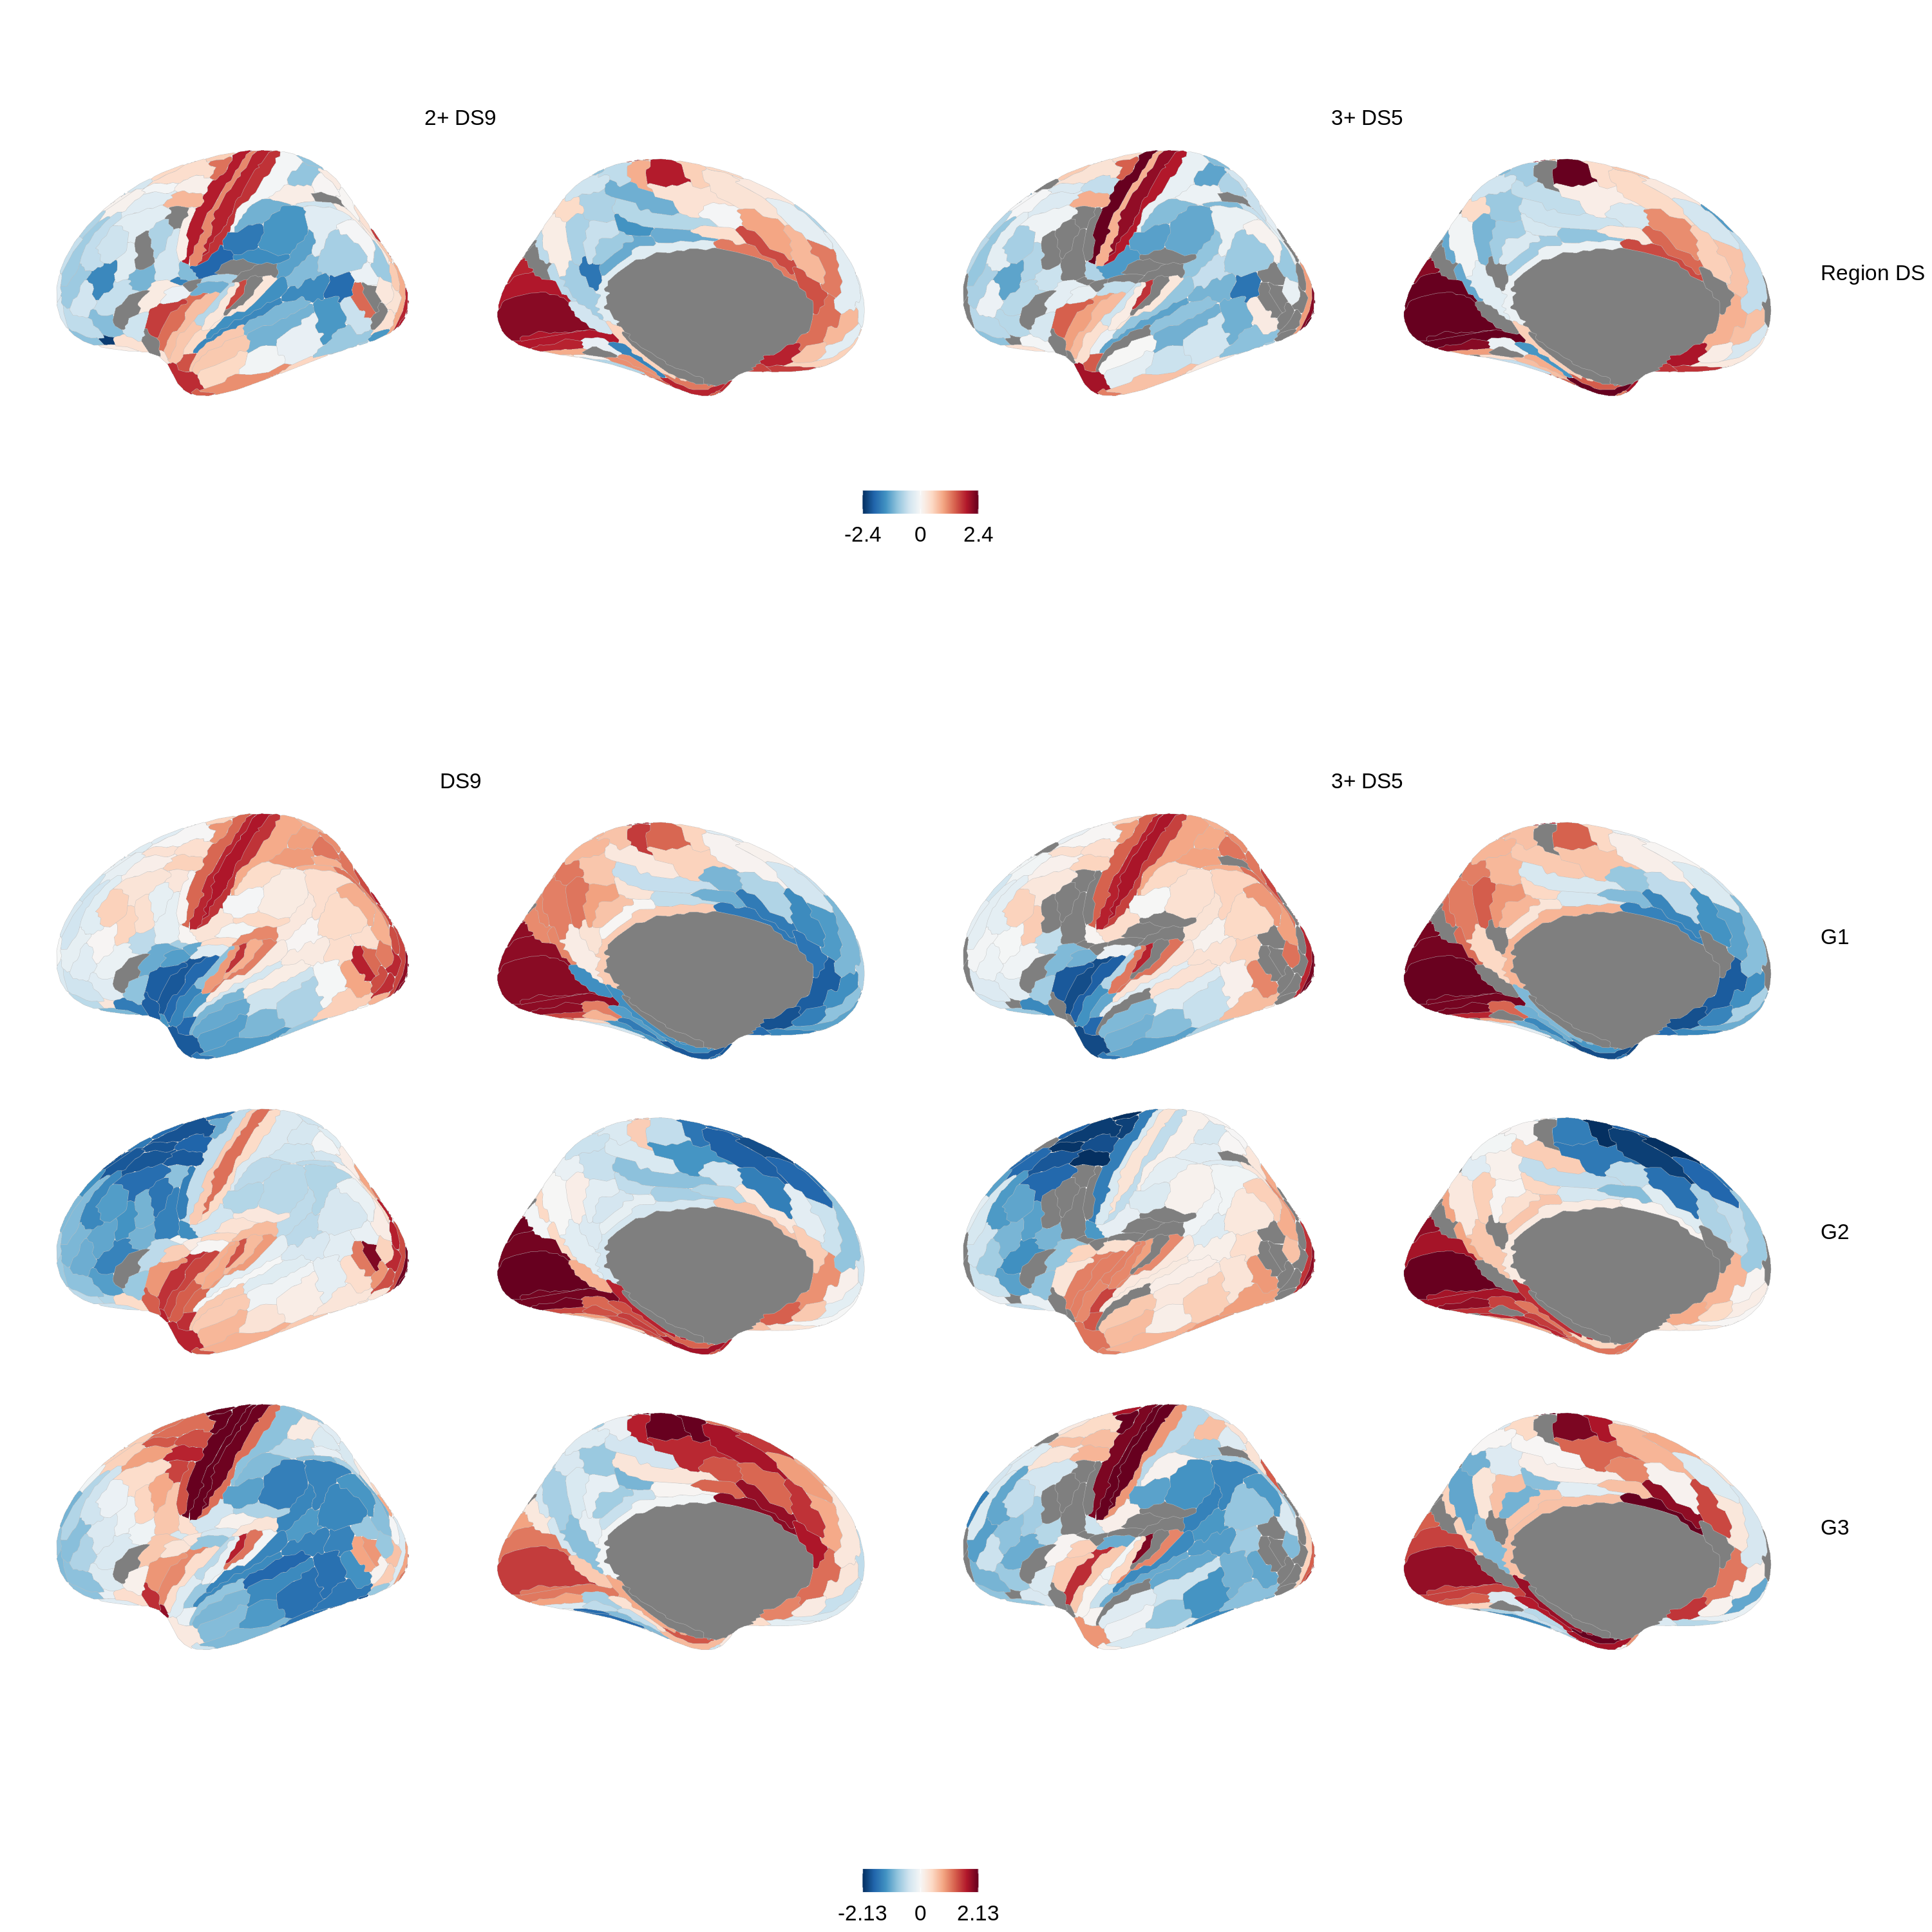

In [93]:
%%R -w 20 -h 20 --units in -r 150 -i region_ds_plot -i hcp_scores
g1 <- plot_hcp(region_ds_plot, facet='h') & theme(text=element_text(size=20))
g2 <- plot_hcp(hcp_scores, facet='h') & theme(text=element_text(size=20))
g1 / g2 + plot_layout(heights=c(1,3))

In [72]:
dm_hcp_3d_ds5.clean_scores().set_index('label').join(region_ds.set_index('label')).corr().iloc[:3,3:]

,2+ DS9,3+ DS5
G1,-0.181068,-0.142844
G2,-0.199684,-0.221147
G3,0.598124,0.591058


In [77]:
dm_hcp_ds9.clean_scores().set_index('label').join(region_ds.set_index('label')).corr().iloc[:3,3:]

,2+ DS9,3+ DS5
G1,-0.090461,-0.121313
G2,-0.492686,-0.506742
G3,0.572214,0.586841


In [14]:
def make_scatter(version, region_ds_version):
    out = (
        version.clean_scores().set_index('label')
        .join(region_ds.set_index('label'))
        .loc[:,['G2', region_ds_version]]
        .rename({region_ds_version:'region_ds'},axis=1)
    )
    return out

region_ds_scatter = {
    # 'DS9': make_scatter(dm_hcp_ds9, '2+ DS9'),
    '3+ DS5': make_scatter(dm_hcp_3d_ds5, '3+ DS5')
}

region_ds_scatter = (
    pd.concat(region_ds_scatter)
    .reset_index(0).rename({'level_0':'version'},axis=1)
)
region_ds_scatter

,version,G2,region_ds
label,,,
V1,3+ DS5,-2.126130,3.081942
V2,3+ DS5,-1.773014,2.400575
V3,3+ DS5,-1.899824,2.189361
V4,3+ DS5,-1.544960,1.013384
4,3+ DS5,1.470914,2.431206
...,...,...,...
A4,3+ DS5,-0.216136,-0.932845
STSva,3+ DS5,-0.567175,-0.008529
TE1m,3+ DS5,-0.128243,-0.522566


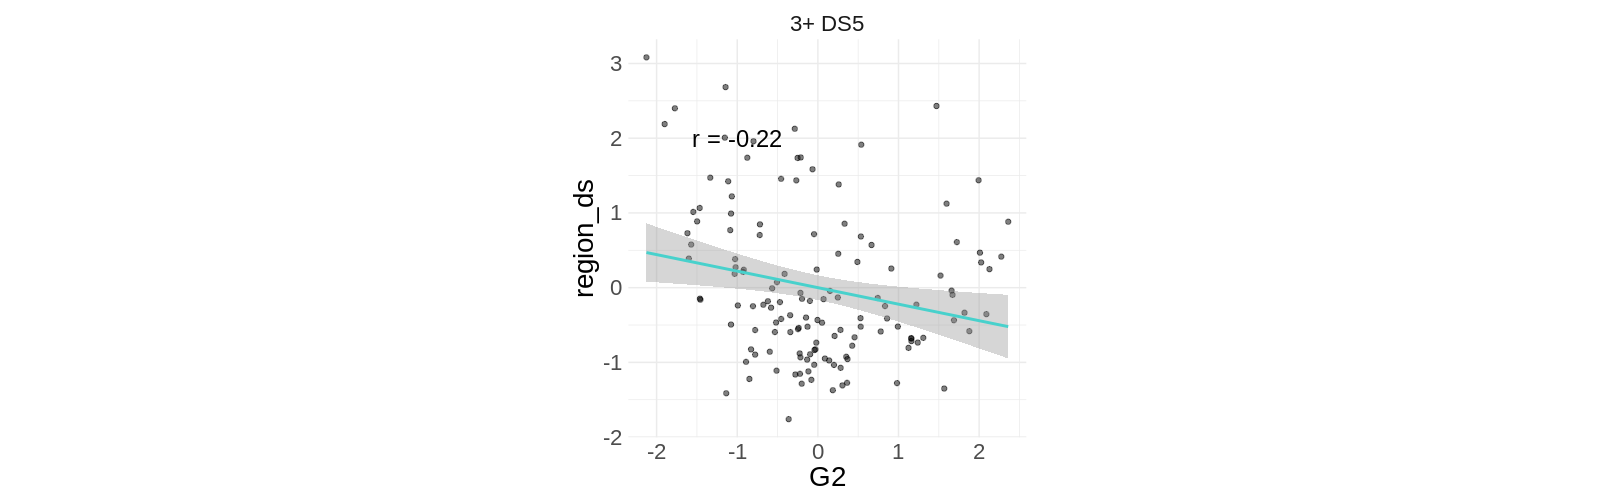

In [16]:
%%R -w 16 -h 5 --units in -r 100 -i region_ds_scatter
corrs <- region_ds_scatter %>%
    group_by(version) %>% summarize(cor(G2, region_ds, use='p')) %>%
    mutate(version = factor(version, ordered=T, levels=unique(.$version)))
names(corrs) <- c('version', 'r')

region_ds_scatter %>%
mutate(version = factor(version, ordered=T, levels=unique(.$version))) %>%
ggplot(aes(x=G2, y=region_ds)) +
facet_wrap(~version) +
geom_point(alpha=.5) +
geom_smooth(color='mediumturquoise', method='lm') +
geom_text(data=corrs, x=-1, y=2, aes(label=paste('r =', round(r, 2))), size=6) +
theme_minimal() +
theme(aspect.ratio=1, text=element_text(size=20), panel.spacing=unit(18, 'lines'))

In [86]:
scores = dm_hcp_3d_ds5.clean_scores()
null_scores = np.load("../outputs/permutations/hcp_3d_ds5_sim_10000.npy")

In [87]:
true_corrs = get_corrs(scores, region_ds.set_index('label'))
null_corrs = corr_nulls_from_grads(null_scores, scores, region_ds.set_index('label'))

In [89]:
get_null_p(true_corrs, null_corrs)

0    0.27456
1    0.20730
2    0.00000
3    0.33620
4    0.19400
5    0.00000
Name: q, dtype: float64